In [5]:
import pandas as pd
cities = pd.read_csv("CitiesDB_new.csv")
cities.head(5)

Name        Country continent iso2 iso3      lat       lng  \
0  Antananarivo     Madagascar    Africa   MG  MDG -18.9333   47.5167   
1       Abidjan  Cote d'Ivoire    Africa   CI  CIV   5.3680   -3.9490   
2       Yaounde       Cameroon    Africa   CM  CMR  11.5200    3.8620   
3        Lusaka         Zambia    Africa   ZM  ZMB -15.4120   28.3060   
4         Hanoi        Vietnam      Asia   VN  VNM  21.0283  105.8542   

   population     Cx(lon)    Cy(lat)  pop_16_UN  pop_23_UN  
0   2500317.0   47.521645 -18.915558   2757.316   3872.264  
1   4717347.0   -4.019603   5.325226   4658.790   5686.350  
2         NaN   11.519136   3.861478   3272.870   4509.287  
3   2426689.0   28.305420 -15.419187   2294.091   3181.250  
4   8246600.0  105.836033  21.030436   3854.847   5253.385

Fitted parameters:
  kappa = -1.7966 (95% CI: -1.8403, -1.7528)
  delta = -0.5544 (95% CI: -0.5751, -0.5337)


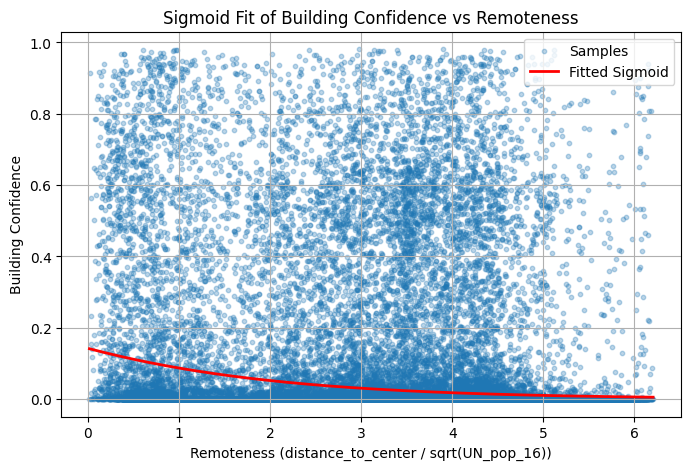

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def sigmoid(x, kappa, delta):
    return 1 / (1 + np.exp(-(kappa + delta * x)))

def sample_and_fit_sigmoid(df, pop, sample_size=100000, random_state=72):
    np.random.seed(random_state)
    df_sample = df.sample(n=sample_size, random_state=random_state).copy()
    
    # 计算remoteness
    df_sample['remoteness'] = (df_sample['distance_to_center'] / np.sqrt(pop))*1000
    
    xdata = df_sample['remoteness'].values
    ydata = df_sample['building_confidence'].values
    
    # 拟合 sigmoid 函数
    p0 = [0, -0.01]  # 初始猜测参数：kappa, delta
    params, covariance = curve_fit(sigmoid, xdata, ydata, p0=p0, maxfev=10000)
    kappa, delta = params
    
    # 计算95%置信区间
    se = np.sqrt(np.diag(covariance))
    ci_lower = params - 1.96 * se
    ci_upper = params + 1.96 * se
    
    print(f"Fitted parameters:")
    print(f"  kappa = {kappa:.4f} (95% CI: {ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
    print(f"  delta = {delta:.4f} (95% CI: {ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
    
    # 绘图
    plt.figure(figsize=(8, 5))
    plt.scatter(xdata, ydata, s=10, alpha=0.3, label='Samples')
    
    x_fit = np.linspace(xdata.min(), xdata.max(), 500)
    y_fit = sigmoid(x_fit, kappa, delta)
    plt.plot(x_fit, y_fit, color='red', lw=2, label='Fitted Sigmoid')
    
    plt.xlabel('Remoteness (distance_to_center / sqrt(UN_pop_16))')
    plt.ylabel('Building Confidence')
    plt.title('Sigmoid Fit of Building Confidence vs Remoteness')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return params, covariance, df_sample

# 用法示例，传入你的df和人口数
pop_16 = cities.loc[cities['Name'] == 'Mumbai', 'pop_16_UN'].iloc[0] * 1000
pop_23 = cities.loc[cities['Name'] == 'Mumbai', 'pop_23_UN'].iloc[0] * 1000
params_16, cov_16, df_sample_16 = sample_and_fit_sigmoid(df16, pop=pop_16)
params_23, cov_23, df_sample_23 = sample_and_fit_sigmoid(df23, pop=pop_23)

In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 二次项 sigmoid 函数
def quad_sigmoid(x, kappa, delta1, delta2):
    return 1 / (1 + np.exp(-(kappa + delta1 * x + delta2 * x**2)))

# 拟合函数封装
def sample_and_fit_quad_sigmoid(df, pop, sample_size=100000, random_state=72):
    np.random.seed(random_state)
    df_sample = df.sample(n=sample_size, random_state=random_state).copy()

    # 计算 remoteness
    df_sample['remoteness'] = (df_sample['distance_to_center'] / np.sqrt(pop)) * 1000

    xdata = df_sample['remoteness'].values
    ydata = df_sample['building_confidence'].values

    # 初始参数猜测：kappa, delta1, delta2
    p0 = [0, -0.01, 0.0]
    params, covariance = curve_fit(
        quad_sigmoid, xdata, ydata, p0=p0, maxfev=10000
    )
    kappa, delta1, delta2 = params

    # 计算 95% 置信区间
    se = np.sqrt(np.diag(covariance))
    ci_lower = params - 1.96 * se
    ci_upper = params + 1.96 * se

    print("Fitted parameters:")
    print(f"  kappa   = {kappa:.4f} (95% CI: {ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
    print(f"  delta1  = {delta1:.4f} (95% CI: {ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
    print(f"  delta2  = {delta2:.4f} (95% CI: {ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

    # 绘图
    plt.figure(figsize=(8, 5))
    plt.scatter(xdata, ydata, s=10, alpha=0.3, label='Samples')

    x_fit = np.linspace(xdata.min(), xdata.max(), 500)
    y_fit = quad_sigmoid(x_fit, *params)
    plt.plot(x_fit, y_fit, color='red', lw=2, label='Fitted Quad Sigmoid')

    plt.xlabel('Remoteness (distance_to_center / sqrt(UN_pop_16))')
    plt.ylabel('Building Confidence')
    plt.title('Quadratic Sigmoid Fit of Building Confidence vs Remoteness')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return params, covariance, df_sample

# 定义二次项指数函数
def height_model(remoteness, alpha, beta, gamma):
    return alpha * np.exp(-beta * remoteness + gamma * remoteness**2)

# 拟合函数封装
def sample_and_fit_height_model(df, pop, sample_size=100000, random_state=72):
    df = df[(df['building_height'] > 1) & (df['building_confidence'] != 0)].copy()
    np.random.seed(random_state)
    df_sample = df.sample(n=sample_size, random_state=random_state).copy()
    # df_sample = df.copy()

    # 计算 remoteness
    df_sample['remoteness'] = (df_sample['distance_to_center'] / np.sqrt(pop)) * 1000

    xdata = df_sample['remoteness'].values
    ydata = df_sample['building_height'].values

    # 初始参数猜测：alpha, beta, gamma
    p0 = [20, 0, 0.1]
    params, covariance = curve_fit(
        height_model, xdata, ydata, p0=p0, maxfev=10000
    )
    alpha, beta, gamma= params

    # 计算 95% 置信区间
    se = np.sqrt(np.diag(covariance))
    ci_lower = params - 1.96 * se
    ci_upper = params + 1.96 * se

    print("Fitted parameters:")
    print(f"  alpha   = {alpha:.4f} (95% CI: {ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
    print(f"  beta    = {beta:.4f} (95% CI: {ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
    print(f"  gamma   = {gamma:.4f} (95% CI: {ci_lower[2]:.4f}, {ci_upper[2]:.4f})")
    
    # 绘图
    plt.figure(figsize=(8, 5))
    plt.scatter(xdata, ydata, s=10, alpha=0.3, color='grey', label='Samples')

    x_fit = np.linspace(xdata.min(), xdata.max(), 500)
    y_fit = height_model(x_fit, *params)
    plt.plot(x_fit, y_fit, color='green', lw=2, label='Fitted Height Curve')

    plt.xlabel('Remoteness')
    plt.ylabel('Building Height (m)')
    plt.title('Quadratic Exponential Fit of Building Height vs Remoteness')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return params, covariance, df_sample

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

# 指数+二次项拟合函数
def height_model(x, alpha, beta, gamma):
    return alpha * np.exp(-beta * x + gamma * x**2)

def analyze_remoteness_height_trends(df, pop, sample_size=100000, random_state=42,
                                      n_bins=60, frac_lowess=0.05, quantile=0.9):
    # 1. 数据筛选 + 采样（如有需要）
    df = df[(df['building_height'] > 1) & (df['building_confidence'] != 0)].copy()
    np.random.seed(random_state)
    if sample_size < len(df):
        df_sample = df.sample(n=sample_size, random_state=random_state).copy()
    else:
        df_sample = df.copy()

    # 2. 计算 remoteness
    df_sample['remoteness'] = (df_sample['distance_to_center'] / np.sqrt(pop)) * 1000

    xdata = df_sample['remoteness'].values
    ydata = df_sample['building_height'].values

    # 3. 高楼加权拟合（用全部像素点）
    weights = 1 + (ydata > 20) * 10  # 高楼权重提高10倍
    p0 = [10, 0.5, 0.02]  # 初始参数猜测

    try:
        params_fit, cov_fit = curve_fit(height_model, xdata, ydata, p0=p0, sigma=weights, maxfev=10000)
    except RuntimeError:
        print("⚠️ 拟合失败，使用默认参数")
        params_fit = p0
        cov_fit = np.eye(3)

    # 4. Binned 90% quantile 曲线
    bins = np.linspace(df_sample['remoteness'].min(), df_sample['remoteness'].max(), n_bins + 1)
    df_sample['remoteness_bin'] = pd.cut(df_sample['remoteness'], bins)
    quantile_height = df_sample.groupby('remoteness_bin', observed=False)['building_height'].quantile(quantile)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    valid_bins = ~quantile_height.isna()
    x_binned = bin_centers[valid_bins.values]
    y_binned = quantile_height.values[valid_bins.values]

    # 5. LOWESS 拟合
    lowess_smoothed = lowess(ydata, xdata, frac=frac_lowess, return_sorted=True)
    x_lowess, y_lowess = lowess_smoothed[:, 0], lowess_smoothed[:, 1]

    # 6. 可视化
    x_fit = np.linspace(xdata.min(), xdata.max(), 300)
    y_fit = height_model(x_fit, *params_fit)

    plt.figure(figsize=(12, 6))
    plt.scatter(xdata, ydata, s=1, alpha=0.05, label='All Pixels', color='gray')
    plt.plot(x_fit, y_fit, color='green', linewidth=2, label='Weighted Exp-Quadratic Fit')
    plt.plot(x_binned, y_binned, color='orange', linewidth=2, linestyle='--', label=f'{int(quantile*100)}th Percentile (Binned)')
    plt.plot(x_lowess, y_lowess, color='blue', linewidth=2, linestyle=':', label=f'LOWESS (frac={frac_lowess})')

    plt.xlabel("Remoteness (distance / sqrt(pop))")
    plt.ylabel("Building Height (m)")
    plt.title("Building Height vs Remoteness – Multi-Trend Fit")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 输出参数
    alpha, beta, gamma = params_fit
    se = np.sqrt(np.diag(cov_fit))
    ci_lower = params_fit - 1.96 * se
    ci_upper = params_fit + 1.96 * se

    print("\n📈 Weighted Exp-Quadratic Fit Parameters:")
    print(f"  alpha = {alpha:.4f} (95% CI: {ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
    print(f"  beta  = {beta:.4f} (95% CI: {ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
    print(f"  gamma = {gamma:.4f} (95% CI: {ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

    return params_fit, cov_fit, df_sample

In [61]:
import pandas as pd
df16 = pd.read_csv('pixel_data/Mumbai_2016_all_pixels_confidence.csv')
df23 = pd.read_csv('pixel_data/Mumbai_2023_all_pixels_confidence.csv')

Fitted parameters:
  kappa   = -0.8985 (95% CI: -0.9487, -0.8484)
  delta1  = -1.5797 (95% CI: -1.6330, -1.5263)
  delta2  = 0.2038 (95% CI: 0.1941, 0.2135)


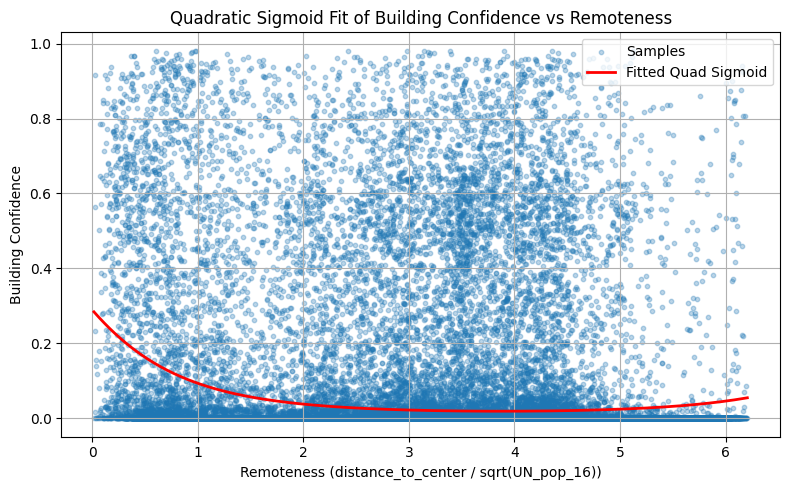

Fitted parameters:
  kappa   = -0.8868 (95% CI: -0.9361, -0.8375)
  delta1  = -1.6876 (95% CI: -1.7429, -1.6324)
  delta2  = 0.2289 (95% CI: 0.2184, 0.2394)


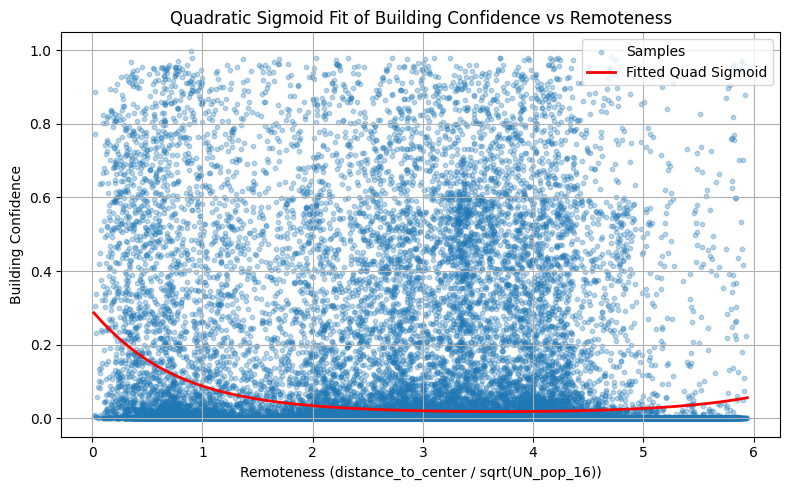

Fitted parameters:
  alpha   = 12.4114 (95% CI: 12.1589, 12.6638)
  beta    = 0.2362 (95% CI: 0.2174, 0.2550)
  gamma   = 0.0309 (95% CI: 0.0273, 0.0346)


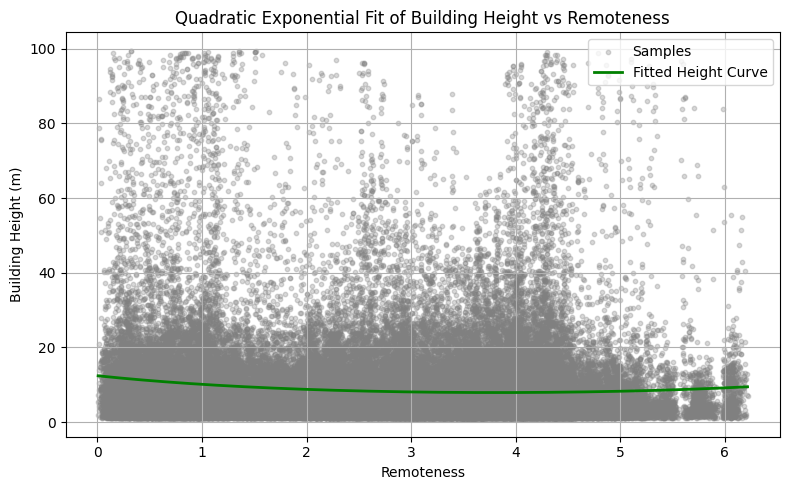

Fitted parameters:
  alpha   = 12.4874 (95% CI: 12.2202, 12.7545)
  beta    = 0.2491 (95% CI: 0.2284, 0.2698)
  gamma   = 0.0342 (95% CI: 0.0301, 0.0383)


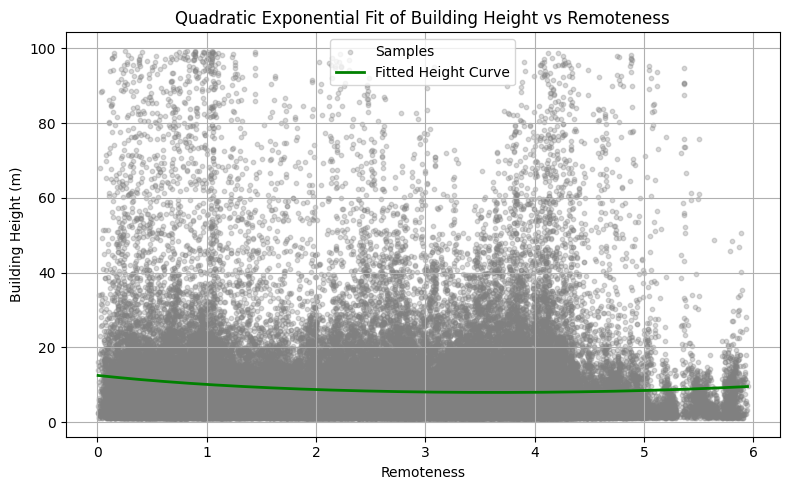

In [62]:
# 使用 UN 人口估计（注意单位是千人）
pop_16 = cities.loc[cities['Name'] == 'Mumbai', 'pop_16_UN'].iloc[0] * 1000
pop_23 = cities.loc[cities['Name'] == 'Mumbai', 'pop_23_UN'].iloc[0] * 1000

params_16, cov_16, df_sample_16 = sample_and_fit_quad_sigmoid(df16, pop=pop_16)
params_23, cov_23, df_sample_23 = sample_and_fit_quad_sigmoid(df23, pop=pop_23)

params_16_h, cov_16_h, df_sample_16_h = sample_and_fit_height_model(df16, pop=pop_16)
params_23_h, cov_23_h, df_sample_23_h = sample_and_fit_height_model(df23, pop=pop_23)

In [63]:
df16 = pd.read_csv('pixel_data/Antananarivo_2016_all_pixels_confidence.csv')
df23 = pd.read_csv('pixel_data/Antananarivo_2023_all_pixels_confidence.csv')

Fitted parameters:
  kappa   = -0.3628 (95% CI: -0.3995, -0.3260)
  delta1  = -0.6252 (95% CI: -0.6452, -0.6052)
  delta2  = 0.0185 (95% CI: 0.0164, 0.0207)


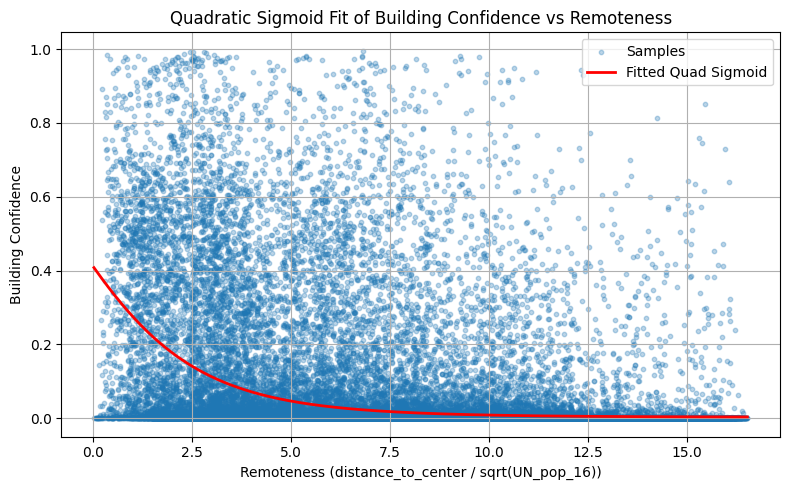

Fitted parameters:
  kappa   = -0.3743 (95% CI: -0.4118, -0.3369)
  delta1  = -0.6330 (95% CI: -0.6560, -0.6101)
  delta2  = 0.0172 (95% CI: 0.0144, 0.0201)


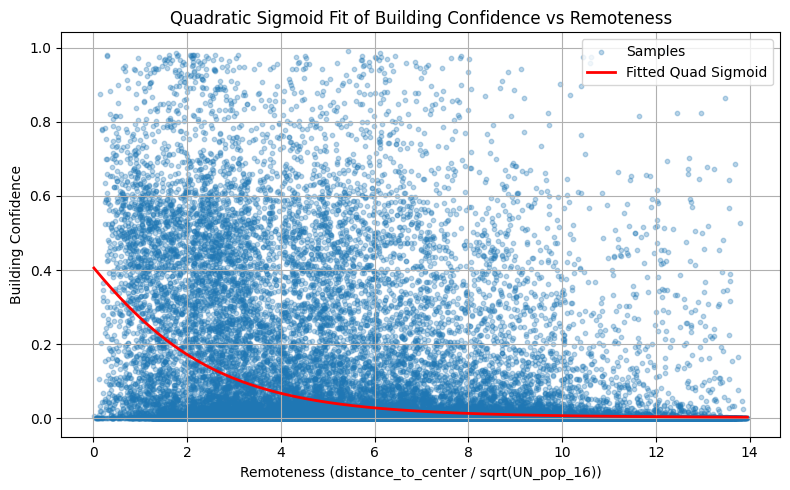

Fitted parameters:
  alpha   = 4.9221 (95% CI: 4.8714, 4.9728)
  beta    = 0.0994 (95% CI: 0.0952, 0.1037)
  gamma   = 0.0045 (95% CI: 0.0042, 0.0048)


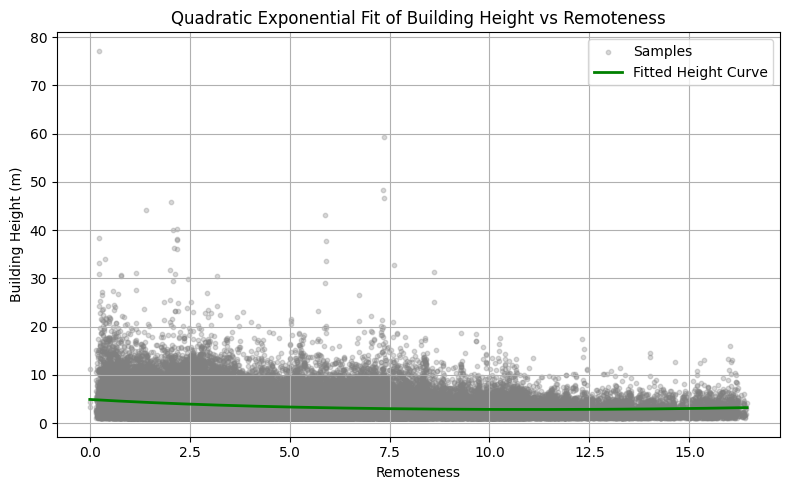

Fitted parameters:
  alpha   = 5.2741 (95% CI: 5.2162, 5.3320)
  beta    = 0.1264 (95% CI: 0.1211, 0.1317)
  gamma   = 0.0065 (95% CI: 0.0061, 0.0070)


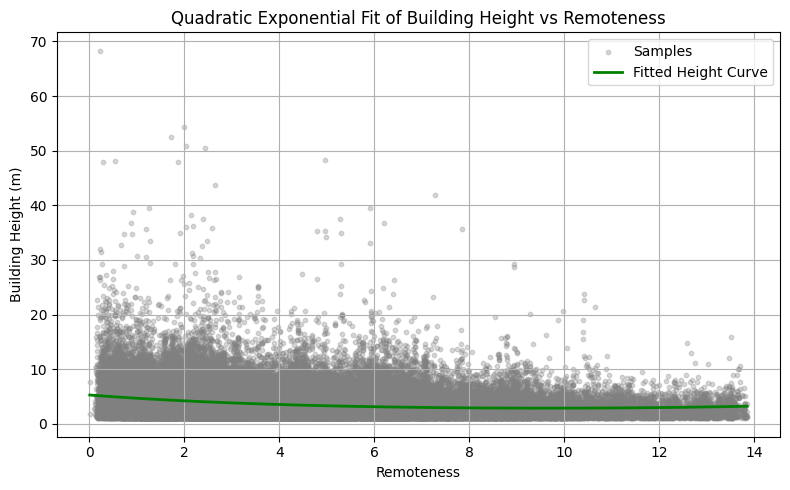

In [64]:
# 使用 UN 人口估计（注意单位是千人）
pop_16 = cities.loc[cities['Name'] == 'Antananarivo', 'pop_16_UN'].iloc[0] * 1000
pop_23 = cities.loc[cities['Name'] == 'Antananarivo', 'pop_23_UN'].iloc[0] * 1000

params_16, cov_16, df_sample_16 = sample_and_fit_quad_sigmoid(df16, pop=pop_16)
params_23, cov_23, df_sample_23 = sample_and_fit_quad_sigmoid(df23, pop=pop_23)

params_16_h, cov_16_h, df_sample_16_h = sample_and_fit_height_model(df16, pop=pop_16)
params_23_h, cov_23_h, df_sample_23_h = sample_and_fit_height_model(df23, pop=pop_23)

In [2]:
df16 = pd.read_csv('pixel_data/Mexico City_2016_all_pixels_confidence.csv')
df23 = pd.read_csv('pixel_data/Mexico City_2023_all_pixels_confidence.csv')

Fitted parameters:
  kappa   = -0.5394 (95% CI: -0.5848, -0.4940)
  delta1  = -0.0074 (95% CI: -0.0435, 0.0286)
  delta2  = -0.0622 (95% CI: -0.0688, -0.0555)


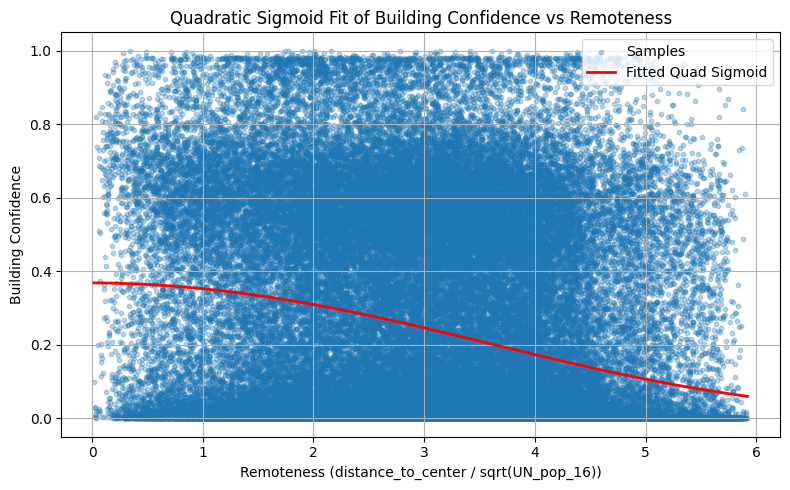

Fitted parameters:
  kappa   = -0.4949 (95% CI: -0.5401, -0.4497)
  delta1  = -0.0405 (95% CI: -0.0768, -0.0042)
  delta2  = -0.0553 (95% CI: -0.0620, -0.0486)


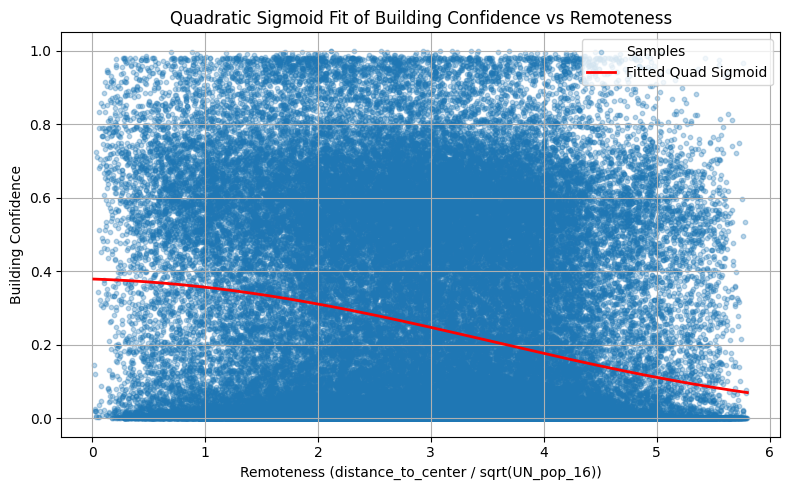

Fitted parameters:
  alpha   = 8.1629 (95% CI: 7.9916, 8.3342)
  beta    = 0.2282 (95% CI: 0.2107, 0.2457)
  gamma   = 0.0174 (95% CI: 0.0141, 0.0207)


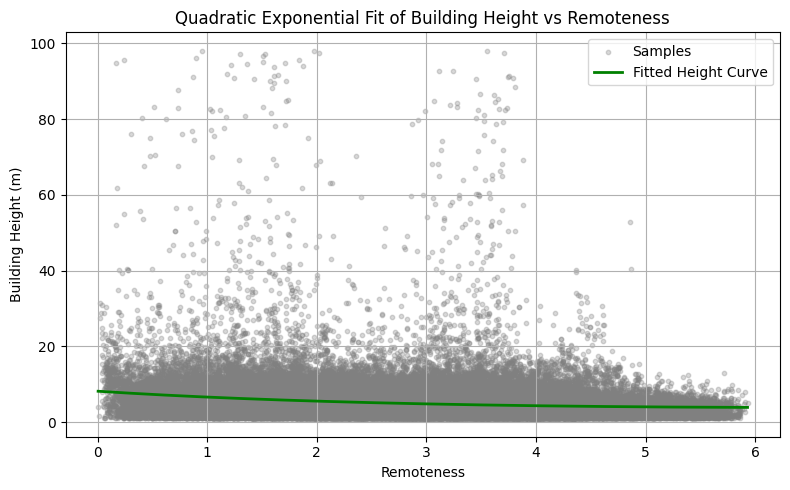

Fitted parameters:
  alpha   = 7.6003 (95% CI: 7.4219, 7.7787)
  beta    = 0.1854 (95% CI: 0.1657, 0.2051)
  gamma   = 0.0111 (95% CI: 0.0073, 0.0148)


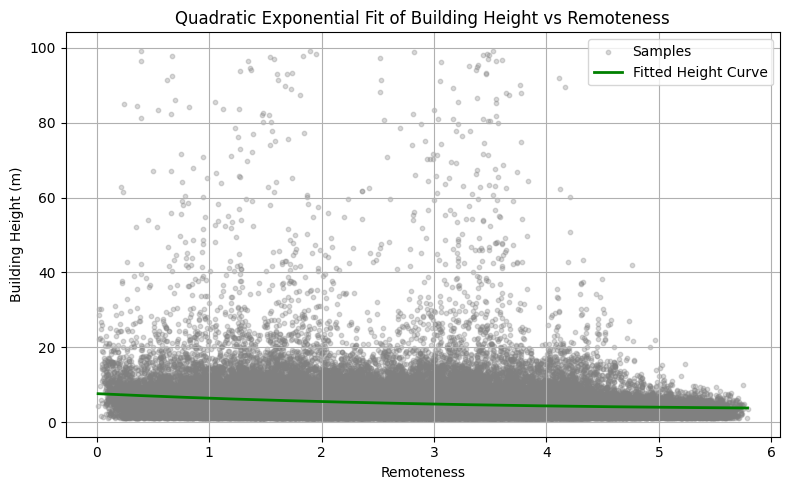

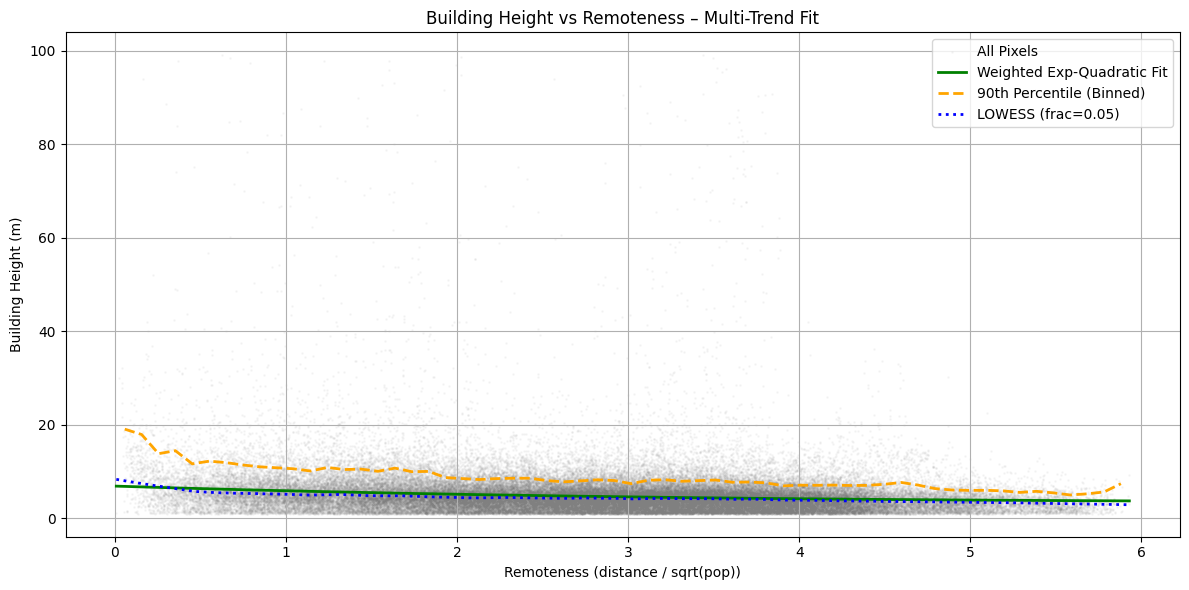


📈 Weighted Exp-Quadratic Fit Parameters:
  alpha = 6.9223 (95% CI: 6.8205, 7.0241)
  beta  = 0.1674 (95% CI: 0.1555, 0.1793)
  gamma = 0.0109 (95% CI: 0.0087, 0.0131)


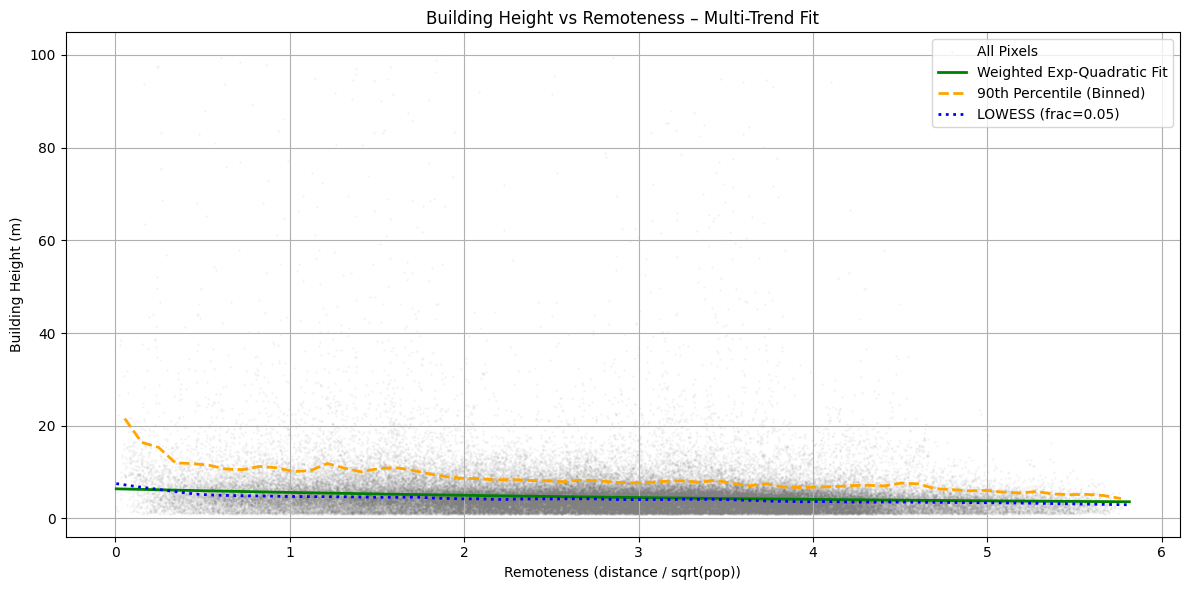


📈 Weighted Exp-Quadratic Fit Parameters:
  alpha = 6.3927 (95% CI: 6.2927, 6.4927)
  beta  = 0.1368 (95% CI: 0.1240, 0.1496)
  gamma = 0.0065 (95% CI: 0.0041, 0.0089)


In [7]:
# 使用 UN 人口估计（注意单位是千人）
pop_16 = cities.loc[cities['Name'] == 'Mexico City', 'pop_16_UN'].iloc[0] * 1000
pop_23 = cities.loc[cities['Name'] == 'Mexico City', 'pop_23_UN'].iloc[0] * 1000

params_16, cov_16, df_sample_16 = sample_and_fit_quad_sigmoid(df16, pop=pop_16)
params_23, cov_23, df_sample_23 = sample_and_fit_quad_sigmoid(df23, pop=pop_23)

params_16_h, cov_16_h, df_sample_16_h = sample_and_fit_height_model(df16, pop=pop_16)
params_23_h, cov_23_h, df_sample_23_h = sample_and_fit_height_model(df23, pop=pop_23)

params_16_ht, cov_16_ht, df_sample_16_ht = analyze_remoteness_height_trends(df16, pop=pop_16)
params_23_ht, cov_23_ht, df_sample_23_ht = analyze_remoteness_height_trends(df23, pop=pop_23)

In [8]:
df = pd.read_csv('pixel_data/Mumbai_2016_all_pixels_confidence.csv')

(array([14870721.,   207604.,   145915.,   129502.,   146009.,   171797.,
          127652.,    92670.,    75423.,    44709.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

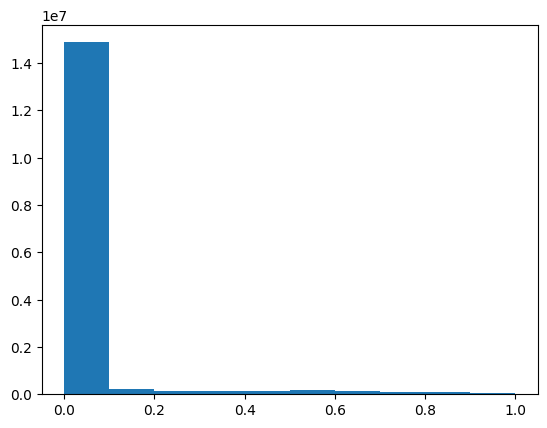

In [30]:
df['remoteness']=(df['distance_to_center']/np.sqrt(19534652))*1000
plt.hist(df['building_confidence'],bins=10)